In [1]:
import os
from pathlib import Path
from omegaconf import OmegaConf
from copy import deepcopy
from typing import List, Union, Dict, Any

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report

os.chdir("../src")  # Change to project root directory

from config import DatasetConfig, ConceptDatasetConfig
from models.architectures import CBMSequentialEfficientNetFCN
from config import CBMTrainerConfig
from models.trainer.cbm_trainer import CBMTrainer
from models.architectures import EfficientNetv2
from models.trainer.standard_trainer import StandardTrainer
from config.training_config import TrainingConfig
from config.training_config import ConceptTrainingConfig

2025-10-23 23:18:14.507097: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-23 23:18:14.521879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761254294.538428   64246 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761254294.543488   64246 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-23 23:18:14.561025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Loading results

In [2]:
rq1_results_path = Path("./experiments/RQ/Results")
(rq1_results_path / 'plots').mkdir(exist_ok=True)

In [ ]:
baseline_cnn = pd.read_excel(rq1_results_path / "BaselineCNN_label_results.xlsx").rename(columns={'Unnamed: 0':'seed'})
vanilla_cbm_labels = pd.read_excel(rq1_results_path / "VanillaCBM_label_results.xlsx").rename(columns={'Unnamed: 0':'seed'})
vanilla_cbm_concepts = pd.read_excel(rq1_results_path / "VanillaCBM_concept_results.xlsx").rename(columns={'Unnamed: 0':'seed'})
reqaware_cbm_labels = pd.read_excel(rq1_results_path / "ReqAware_label_results.xlsx").rename(columns={'Unnamed: 0':'seed'})
reqaware_cbm_concepts = pd.read_excel(rq1_results_path / "ReqAware_concept_results.xlsx").rename(columns={'Unnamed: 0':'seed'})

In [4]:
columns = ['seed', 'micro_accuracy', 'micro_f1', 'micro_precision', 'micro_recall',
            'macro_accuracy', 'macro_f1', 'macro_precision', 'macro_recall',
            'weighted_accuracy', 'weighted_f1', 'weighted_precision',
            'weighted_recall']

In [5]:
baseline_cnn.columns = columns
baseline_cnn = baseline_cnn.dropna().reset_index(drop=True)

vanilla_cbm_labels.columns = columns
vanilla_cbm_labels = vanilla_cbm_labels.dropna().reset_index(drop=True)

vanilla_cbm_concepts.columns = columns
vanilla_cbm_concepts = vanilla_cbm_concepts.dropna().reset_index(drop=True)

reqaware_cbm_labels.columns = columns
reqaware_cbm_labels = reqaware_cbm_labels.dropna().reset_index(drop=True)

reqaware_cbm_concepts.columns = columns
reqaware_cbm_concepts = reqaware_cbm_concepts.dropna().reset_index(drop=True)

# Accuracy of Label predictions

In [6]:
baseline_cnn_df = baseline_cnn.filter(["macro_accuracy", "macro_f1"]).assign(model_type = 'Baseline CNN').reset_index()
reqaware_cbm_labels_df = reqaware_cbm_labels.filter(["macro_accuracy", "macro_f1"]).assign(model_type = 'ReqAware').reset_index()
vanilla_cbm_labels_df = vanilla_cbm_labels.filter(["macro_accuracy", "macro_f1"]).assign(model_type = 'Vanilla CBM').reset_index()

labels_df = pd.concat([baseline_cnn_df, reqaware_cbm_labels_df, vanilla_cbm_labels_df])
labels_df.columns = ["seed", "accuracy", "macro_f1", "model_type"]
labels_df

labels_df['model_type'] = pd.Categorical(
    labels_df['model_type'], 
    categories=['Baseline CNN', 'Vanilla CBM', 'ReqAware'], 
    ordered=True
)

In [7]:
labels_df.filter(['accuracy', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])

/tmp/ipykernel_64246/2263956479.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labels_df.filter(['accuracy', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])
/tmp/ipykernel_64246/2263956479.py:1: FutureWarning: The provided callable <function mean at 0x7f9a701553a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  labels_df.filter(['accuracy', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])
/tmp/ipykernel_64246/2263956479.py:1: FutureWarning: The provided callable <function median at 0x7f9a70092e80> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep cur

accuracy                    
                  mean    median       std
model_type                                
Baseline CNN  0.990042  0.989945  0.002641
Vanilla CBM   0.987894  0.988242  0.002513
ReqAware       0.98488  0.986936  0.005612

/tmp/ipykernel_64246/2286144470.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


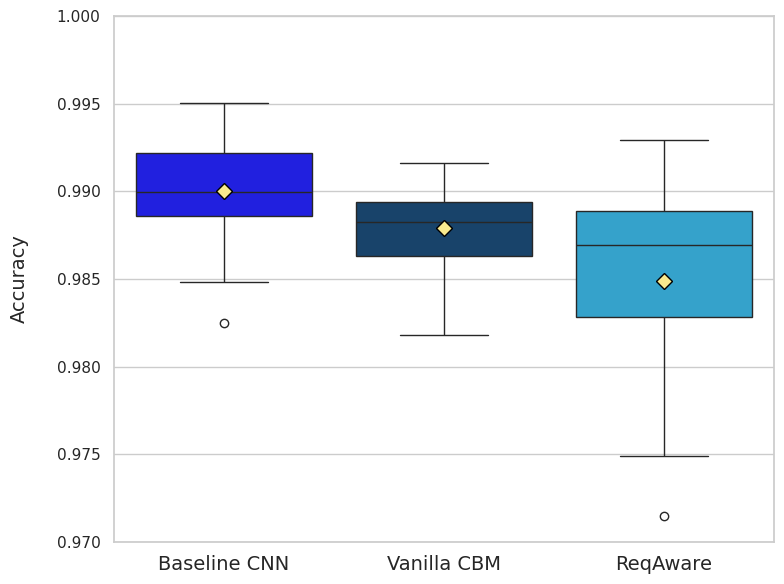

Box plot saved as 'f1_score_box_plot.png'.


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set a clean, academic style
sns.set_theme(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the box plot
sns.boxplot(
    x='model_type',        # The categorical variable (Model Types)
    y='accuracy',          # The metric you want to plot
    data=labels_df,
    ax=ax,
    palette=['#0200ff', '#0b4477', '#1cade4'], # Professional color scheme
    showmeans=True, # 1. Instructs seaborn to plot the mean
    meanline=False, # 2. Plots the mean as a marker (point), not a line
    meanprops={
        "marker": "D", # Use a Diamond marker
        "markerfacecolor": '#f9ea8e', # Fill the marker with red
        "markeredgecolor": "black", # Give the marker a black border
        "markersize": "8" # Adjust the size of the marker
    }
)

# Add titles and labels
# ax.set_title('Distribution of Accuracy on Label Prediction\n', fontsize=16)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Accuracy\n', fontsize=14)

# Ensure the y-axis range is appropriate for performance metrics (0 to 1)
ax.set_ylim(0.97, 1)

# Add tick marks and labels for clarity
ax.tick_params(axis='x', which='major', labelsize=14)

# Optional: Add swarm plot or strip plot on top to show individual data points
# sns.stripplot(
#     x='model_type',
#     y='macro_f1',
#     data=labels_df,
#     color='black',
#     size=5,
#     jitter=True, # Add a small amount of random displacement to prevent overlap
#     alpha=0.6,
#     ax=ax
# )

# Save the figure with high resolution for publication
plt.tight_layout() # Adjusts plot to prevent labels from being cut off
plt.savefig(rq1_results_path / 'plots' / 'RQ1_accuracy_box_plot.png', dpi=300)
# plt.close() # Close the plot to free up memory

plt.show()
print("Box plot saved as 'f1_score_box_plot.png'.")

# Macro F1 of Concept predictions

In [9]:
reqaware_cbm_concepts_df = reqaware_cbm_concepts.filter(["macro_accuracy", "macro_f1"]).assign(model_type = 'ReqAware').reset_index()
vanilla_cbm_concepts_df = vanilla_cbm_concepts.filter(["macro_accuracy", "macro_f1"]).assign(model_type = 'Vanilla CBM').reset_index()

concepts_df = pd.concat([vanilla_cbm_concepts_df, reqaware_cbm_concepts_df])
concepts_df.columns = ["seed", "accuracy", "macro_f1", "model_type"]
concepts_df

concepts_df['model_type'] = pd.Categorical(
    concepts_df['model_type'], 
    categories=['Vanilla CBM', 'ReqAware'], 
    ordered=True
)

In [10]:
concepts_df.filter(['macro_f1', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])

/tmp/ipykernel_64246/1417992198.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  concepts_df.filter(['macro_f1', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])
/tmp/ipykernel_64246/1417992198.py:1: FutureWarning: The provided callable <function mean at 0x7f9a701553a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  concepts_df.filter(['macro_f1', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])
/tmp/ipykernel_64246/1417992198.py:1: FutureWarning: The provided callable <function median at 0x7f9a70092e80> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep

macro_f1                    
                 mean    median       std
model_type                               
Vanilla CBM  0.989605  0.990669  0.002901
ReqAware     0.984029  0.988714  0.010486

/tmp/ipykernel_64246/540814322.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


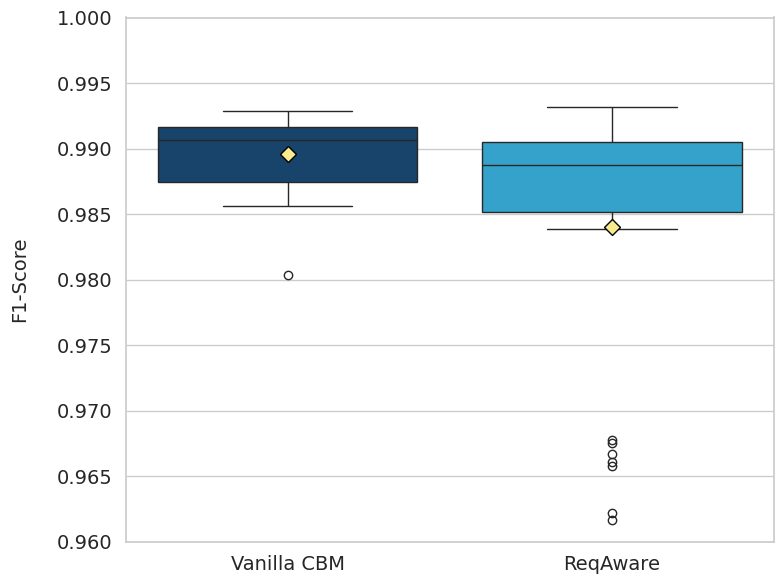

Box plot saved as 'RQ1_concetps_f1_score_box_plot.png'.


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set a clean, academic style
sns.set_theme(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the box plot
sns.boxplot(
    x='model_type',        # The categorical variable (Model Types)
    y='macro_f1',          # The metric you want to plot
    data=concepts_df,
    ax=ax,
    palette=['#0b4477', '#1cade4'], # Professional color scheme
    showmeans=True, # 1. Instructs seaborn to plot the mean
    meanline=False, # 2. Plots the mean as a marker (point), not a line
    meanprops={
        "marker": "D", # Use a Diamond marker
        "markerfacecolor": '#f9ea8e', # Fill the marker with red
        "markeredgecolor": "black", # Give the marker a black border
        "markersize": "8" # Adjust the size of the marker
    }
)

# Add titles and labels
# ax.set_title('Distribution of F1-Scores by Model Type', fontsize=16)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('F1-Score\n', fontsize=14)

# Ensure the y-axis range is appropriate for performance metrics (0 to 1)
ax.set_ylim(0.96, 1)

# Add tick marks and labels for clarity
ax.tick_params(axis='both', which='major', labelsize=14)

# Optional: Add swarm plot or strip plot on top to show individual data points
# sns.stripplot(
#     x='model_type',
#     y='macro_f1',
#     data=labels_df,
#     color='black',
#     size=5,
#     jitter=True, # Add a small amount of random displacement to prevent overlap
#     alpha=0.6,
#     ax=ax
# )

# Save the figure with high resolution for publication
plt.tight_layout() # Adjusts plot to prevent labels from being cut off
plt.savefig(rq1_results_path / 'plots' / 'RQ1_concetps_f1_score_box_plot.png', dpi=300)
# plt.close() # Close the plot to free up memory

plt.show()
print("Box plot saved as 'RQ1_concetps_f1_score_box_plot.png'.")

# Finding the best models

In [12]:
reqaware_cbm_concepts.sort_values(by='macro_f1', ascending=False).filter(['seed','macro_f1']).head(5)

,seed,macro_f1
14,s41,0.9932
26,s269,0.99305
30,s42,0.992883
22,s714,0.991455
8,s229,0.991454


In [13]:
reqaware_cbm_labels.sort_values(by='macro_accuracy', ascending=False).filter(['seed','macro_accuracy']).head(5)

,seed,macro_accuracy
26,s269,0.992953
30,s42,0.990578
25,s712,0.990261
14,s41,0.989786
22,s714,0.989311


In [14]:
vanilla_cbm_concepts.sort_values(by='macro_accuracy', ascending=False).filter(['seed','macro_accuracy']).head(5)

,seed,macro_accuracy
4,s687,0.99137
2,s469,0.991132
20,s41,0.991132
18,s907,0.991053
29,s714,0.990261


In [15]:
vanilla_cbm_labels.sort_values(by='macro_accuracy', ascending=False).filter(['seed','macro_accuracy']).head(5)

,seed,macro_accuracy
18,s907,0.991607
4,s687,0.991607
2,s469,0.991449
20,s41,0.991211
6,s852,0.990499


In [17]:
baseline_cnn.sort_values(by='macro_accuracy', ascending=False).filter(['seed','macro_accuracy']).head(5)

,seed,macro_accuracy
25,s519,0.995012
10,s89,0.993112
16,s852,0.993112
12,s469,0.992953
20,s20,0.992953
